<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0809_keras(AutoEncoder/GAN)/keras(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN(Generative Adversarial Network)
- 생성적 적대 신경망이라고 번역하는데 ```생성적```이라는 것은 ```Generator(생성자)가 학습에 필요한 데이터를 만드는 것```을 나타내고 ```적대적```이라는 것은 ```만들어지는 데이터가 Discriminator(판별자)를 속이기 위한 가짜```이기 때문입니다.
- 설명을 할 때 보톤 경찰관과 위조 지폐를 만드는 범죄자와 비유해서 설명하는 범죄자는 위조 지폐를 만들고 경찰관은 위조 지폐를 판별해서 범죄자를 찾는 방식으로 2개의 모델이 서로 상대적으로 다른 목적을 가지고 경쟁하면서 서로를 발전시키는 방법입니다.
- 판별자에 해당하는 Discrpminator의 목적은 Generator가 생성해 낸 가짜 데이터와 잘 구분하는 것으로 이진 분류 문제를 풀게 되는 반면에 생성자에 해당하는 Generator의 목적은 자신이 만들어 낸 가짜 데이터를 Discriminator가 진짜라고 판단하도록 하는 것입니다.

- 오토 인코더가 10가지임에도 binary를 쓰는 이유는 이진 분류이기 때문입니다.

### 훈련 방법
- 기존의 신경망과는 다른 훈련 방법을 사용하는데 첫번째 단계에서 생성자는 실제 이미지 배치를 샘플링하고 동일한 숫자의 가짜 이미지를 만들어서 합쳐서 레이블링을 하게 되는데 진짜 이미지는 1을 주고 가짜 이미지는 0으로 레이블링을 합니다. 그러면 판별자는 이진 crossentropy를 사용해서 한 스텝동안 배치된 데이터를 훈련하고 판별자의 가중치를 최적화합니다.
- 두번째 단계에서는 가짜 이미지를 만들고 레이블링을 하는데 이번에는 전부 1이라고 레이블링을 하고 판별자가 판별을 해서 진짜라고 믿는 이미지만 사용하고 판별자의 가중치는 동결하고 생성자는 가중치를 최적화합니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "gan"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = 'C:\Windows\Fonts\malgun.TTF'
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


## GAN모델 만들기

In [ ]:
### 데이터 생성
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(55000, 28, 28)
(5000, 28, 28)
(55000,)
(5000,)


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


codings_size = 30

# 생성자 - 디코더와 유사
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# 판별자 - 이진 분류기
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])


### 생성한 모델 컴파일

In [ ]:
# 판별자 컴파일
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
# 가중치를 업데이터하면 안됨
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## GAN모델 훈련
- fit을 사용할 수 없습니다.


In [ ]:
# 데이터를 순회하는 Dataset을 생성해야 합니다.
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
# drop_reminder: 남는것을 어떻게 할 것인가에 대한 설정
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

In [ ]:
len(dataset)

1718

In [ ]:
# 반복문을 이용해서 직접 훈련
def train_gan(gan, dataset, batch_size, coding_size, n_epochs=50):
    # 생성자와 판별자 분리
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("epoch {} / {}".format(epoch+1, n_epochs))
        for X_batch in dataset:
            # 단계 1 - 생성자가 잡음이 섞인 데이터를 만들고 판별자가 훈련
            # 잡음이 섞인 데이터와 원본 데이터를 합쳐서 훈련
            # 랜덤하게 잡음을 추가
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            # 진짜와 가짜들 섞음
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            # 진짜와 가짜 레이블 생성
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # 판별자에게 훈련
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            # 단계 2 - 생성자가 잡음이 섞인 데이터만 생성해서 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]]* batch_size)
            # 판별자에게 훈련
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

epoch 1 / 1


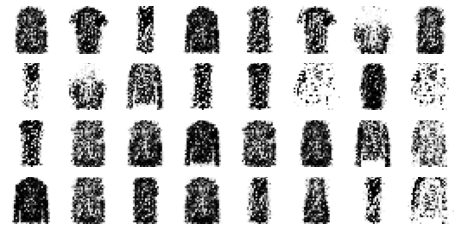

In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

### batch_size만큼의 가짜 이미지 생성

3. 심층 합성곱 GAN(Deep Convolution GAN - DCGAN)
- 합성곱 층을 이용한 GAN

1) 가이드 라인
- 판별자에 있는 풀릉층을 스트라이드 합성곱으로 변경하고 생성자에 있는 풀링층은 전치 합성곱으로 변경
- 생성자와 판별자에 배치 정규화를 사용하는데 생성자의 출력층과 판별자의 입력층을 제외합니다.
- 층을 깊게 쌓기 위해서는 완전 연결 은닉층을 제거하는데 중간에 Dense가 섞여 있으면 안됩니다.
- tanh 함수를 사용해야 하는 출력층을 제외하고 생성자의 모든 층은 ReLu활성화 함수를 사용합니다.
- 판절자의 모든 층은 LeakyReLu()의 활성화 리즘을 

2) 기존의 GAN을 변경

## 심층 합성곱 GAN


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

# 생성자 - 디코더와 유사
generator = keras.models.Sequential([
    
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7 , 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides = 2,
                                padding='SAME', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides = 2,
                                padding='SAME', activation='tanh'),
    
])

# 판별자 - 이진 분류기
discriminator = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                 padding='SAME',
                                 activation=keras.layers.LeakyReLU(0.2),
                                 input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2,
                                 padding="same",
                                 activation = keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
# 모델 생성
gan = keras.models.Sequential([generator, discriminator])
# 판별자 컴파일 
discriminator.compile(loss = 'binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. -1.

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

train_gan(gan, dataset, batch_size, codings_size)

## ProGAN
- 훈련 초기에는 작은 이미지를 생성하고 점진적으로 생성자와 판별자에 합성곱 층을 추가해 갈수록 큰 이미지를 만드는 방법입니다.

- StyleGAN을 탄생시킨 이론적인 배경이 됩니다.

## StyleGAN(= Style Transfer)
- 두장의 서로 다른 이미지를 사용하여 새로운 이미지를 합성하는 방법인데 우리 말로든 스타일 전이라고도 부릅니다.
- CNN을 통해 각 레이어에서 추출되는 다양한 특징을 이용합니다.
- 2개의 이미지가 필요한데 하나는 Contents이미지로 이미지의 구조와 형태를 나타내는 콘텐츠를 추출하기 위한 이미지이고 다른 하나는 스타일 이미지로 이미지 고유의 스타일만을 추출하기 위한 이미지입니다.

### 라이브러리 가져오기

In [ ]:
google content

In [ ]:
import os 
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 주피터에서 작업 진행 상황을 보여주기 위한 패키지입니다.
from tqdm import tqdm
# 이미지 처리를 위한 패키지
import cv2
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


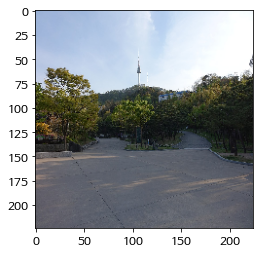

In [ ]:
contents = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/images/contents.jfif")
contents = cv2.resize(contents, (224, 224))
plt.imshow(cv2.cvtColor(contents, cv2.COLOR_BGR2RGB))

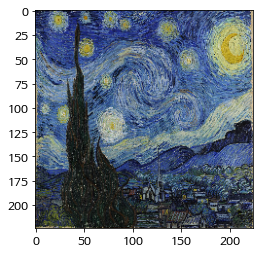

In [ ]:
style = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/images/style.jpg")
style = cv2.resize(style, (224, 224))
plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))

2) Contents 로 사용할 이미지 가져오기

### 사전 학습모델 VGG 16모델을 가져오기
- 스타일 변환 모델(VGG모델)을 가져와서 모델 생성
- include_top=False, # 출력을 가지고 오지 않았으므로, 출력을 만들어야 합니다.


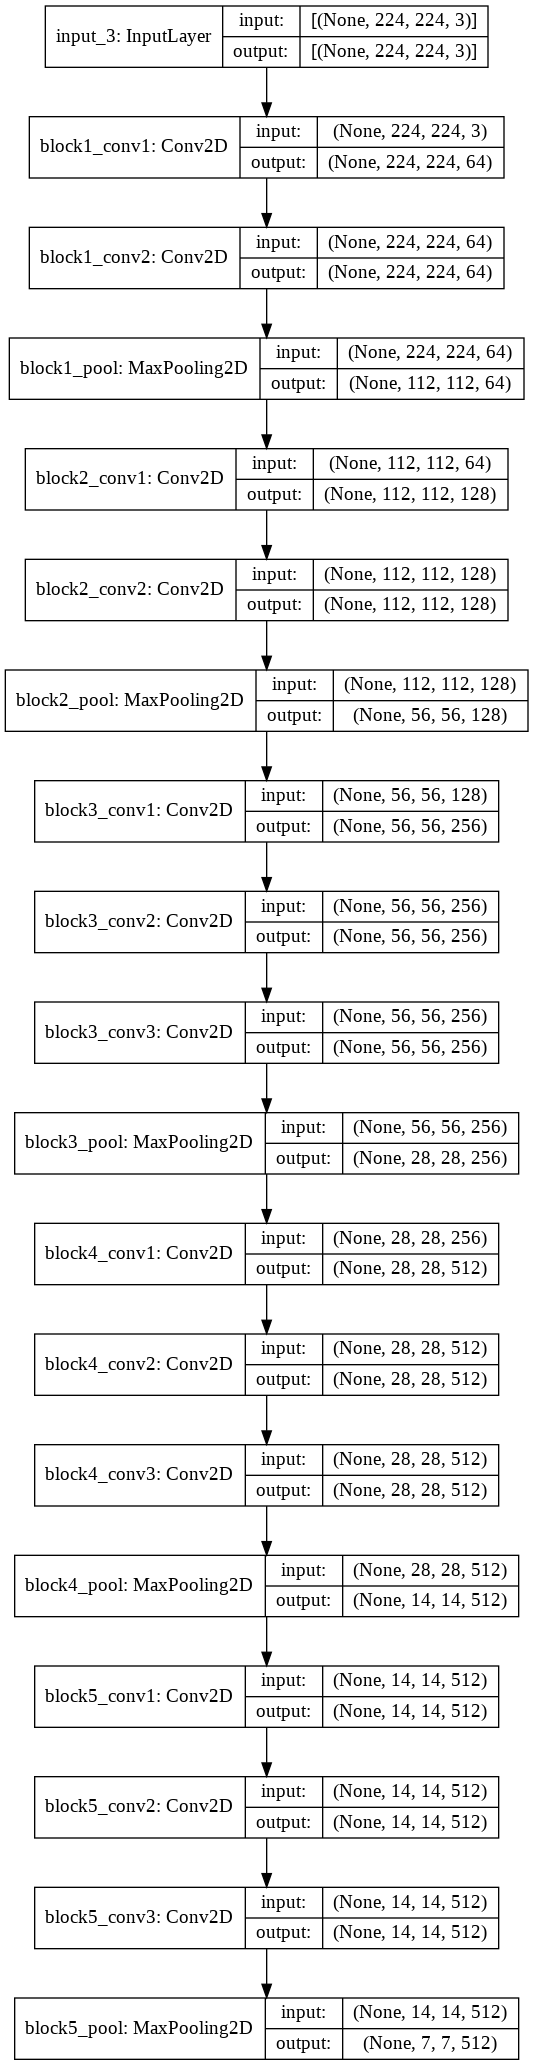

In [ ]:
vgg_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), 
                                        include_top=False, # 출력을 가지고 오지 않았으므로, 출력을 만들어야 합니다.
                                        weights='imagenet')

vgg_model.trainable = False
tf.keras.utils.plot_model(vgg_model, show_shapes=True)

### 사전 훈련된 모델을 바탕으로 스타일 변환 모델을 생성
- 알아두어야 할 것은 모델 층의 이름으로 block1_conv1 ~ conv3를 잘 보고 가져오면 됩니다.

In [ ]:
style_transfer_model = tf.keras.Model(inputs=[vgg_model.input], 
                outputs=[
                        # 모델이 바뀔지 모르므로 뭘보고 쓴건지 잘 알아놔야 합니다.
                        # 각 블럭의 끝을 가져옵니다
                        vgg_model.get_layer(name='block1_conv2').output,
                        vgg_model.get_layer(name='block2_conv2').output,
                        vgg_model.get_layer(name='block3_conv3').output,
                        vgg_model.get_layer(name='block4_conv3').output 
                        # block5는 안집어 넣습니다
                ])
style_transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 스타일 이미지에서 꺼낸 중요 정보를 확인

(1, 224, 224, 64)


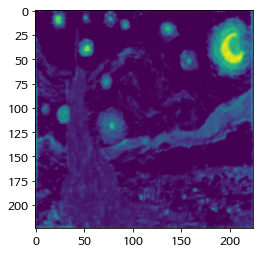

In [ ]:
style_true_b1c1, style_true_b2c3, style_true_b3c3, style_true_b4c3 = style_transfer_model.predict(np.reshape(style, (-1, 224, 224, 3)))

print(style_true_b1c1.shape)
plt.imshow(style_true_b1c1[0][:, :, 60])

### content이미지의 값 확인

(1, 28, 28, 512)


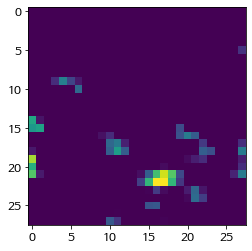

In [ ]:

content_true_b1c1, content_true_b2c2, content_true_b3c3, content_true_b4c3 = style_transfer_model.predict(np.reshape(contents, (-1, 224, 224, 3)))

print(content_true_b4c3.shape)
plt.imshow(content_true_b4c3[0][:, :, 60])

7) Gram Matrix 함수를 정의
=  Gram Matrix : 각 피처의 featue Map 의 Chnnel을 각각 Flatten을 하여 새로 만들어질 이미지와 correlation을 같도록 하는데 이 채널은 Correlation을 표현하도록 함


In [ ]:
def gram_matrix(x):
    # transpose : 행과 열을 치환해주는 함수
    # 2차원은 .T를 이용, 3차원이상은 transpose를 이용합니다
    reshape_x=tf.transpose(x,[2,1,0])
    s = tf.shape(reshape_x)
    reshape_x=tf.reshape(reshape_x,(s[0],s[1]*s[2]))
    reshape_x_t=tf.transpose(reshape_x)
    dot=tf.matmul(reshape_x,reshape_x_t)
    # 형 변환
    dot=tf.cast(dot,dtype='float32')
    dot=dot/tf.cast(tf.shape(reshape_x)[0], tf.float32)/tf.cast(tf.shape(reshape_x)[1], tf.float32)
    return dot


### contents 이미지를 입력값으로 생성

In [ ]:
input_image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/data/images/contents.jfif")
input_image = cv2.resize(input_image, (224, 224))

## 동영상과 옵티마이저 설정

In [ ]:
img_avi = np.zeros((224, 224, 3))
opt = tf.keras.optimizers.Adam(10.0)

fcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('style_transfer.avi', fcc, 10.0, (224, 224))                             

입력 이미지 새성과 동영상과 옵티마이저 설정


In [ ]:
for epoch in range(200):
    input_image=tf.reshape(input_image,(-1,224,224,3))
    input_image=tf.cast(input_image,dtype='float32')
    input_image = tf.Variable(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        
        b1c1,b2c2,b3c3,b4c3=style_transfer_model(input_image)
        s_loss_1=tf.stop_gradient(gram_matrix(style_true_b1c1[0]))-gram_matrix(b1c1[0])
        s_loss_1=tf.reduce_mean(tf.square(s_loss_1))

        s_loss_2=tf.stop_gradient(gram_matrix(style_true_b2c2[0]))-gram_matrix(b2c2[0])
        s_loss_2=tf.reduce_mean(s_loss_2*s_loss_2)

        s_loss_3=tf.stop_gradient(gram_matrix(style_true_b3c3[0]))-gram_matrix(b3c3[0])
        s_loss_3=tf.reduce_mean(s_loss_3*s_loss_3)

        s_loss_4=tf.stop_gradient(gram_matrix(style_true_b4c3[0]))-gram_matrix(b4c3[0])
        s_loss_4=tf.reduce_mean(s_loss_4*s_loss_4)

# 손실 구현
    

In [ ]:
b1c1[0].shape

TensorShape([224, 224, 64])